In [14]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
import os

try:
    os.chdir(r"C:\Users\Eda EROL\OneDrive\veriseti")
    print("Yeni Dizin:", os.getcwd())

except FileNotFoundError:
    print("HATA: Belirtilen dizin bulunamadı.")


Yeni Dizin: C:\Users\Eda EROL\OneDrive\veriseti


In [25]:
import os
import shutil

src_dirs = ["HAM10000_images_part_1", "HAM10000_images_part_2"]
dst_dir = "all_images"


os.makedirs(dst_dir, exist_ok=True)


for folder in src_dirs:
    folder_path = os.path.join(os.getcwd(), folder)
    for file in os.listdir(folder_path):
        src_path = os.path.join(folder_path, file)
        dst_path = os.path.join(dst_dir, file)
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

print(f"Tüm görüntüler '{dst_dir}' klasöründe toplandı. Toplam: {len(os.listdir(dst_dir))} dosya")


Tüm görüntüler 'all_images' klasöründe toplandı. Toplam: 6680 dosya


In [ ]:
import csv

metadata_file = "HAM10000_metadata.csv"
metadata = []

with open(metadata_file, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        metadata.append(row)

print(f"Metadata yüklendi. Toplam satır: {len(metadata)}")

In [27]:
label_map = {
    "akiec": 0,
    "bcc": 1,
    "bkl": 2,
    "df": 3,
    "mel": 4,
    "nv": 5,
    "vasc": 6
}

data_list = []

for item in metadata:
    img_id = item["image_id"]
    label = label_map[item["dx"]]
    img_path = os.path.join(dst_dir, img_id + ".jpg")
    if os.path.exists(img_path):
        data_list.append((img_path, label))

print(f"Toplam kullanılabilir veri: {len(data_list)}")

Toplam kullanılabilir veri: 6680


In [28]:
import random


class_groups = {i: [] for i in range(7)}
for path, label in data_list:
    class_groups[label].append((path, label))

train_list, val_list, test_list = [], [], []

for label, items in class_groups.items():
    random.shuffle(items)
    n = len(items)
    test_n = int(n * 0.15)
    val_n = int(n * 0.15)
    test_list.extend(items[:test_n])
    val_list.extend(items[test_n:test_n+val_n])
    train_list.extend(items[test_n+val_n:])


random.shuffle(train_list)
random.shuffle(val_list)
random.shuffle(test_list)

print(f"Train: {len(train_list)}, Val: {len(val_list)}, Test: {len(test_list)}")

Train: 4682, Val: 999, Test: 999


In [29]:
from torchvision import transforms

IMG_SIZE = 128

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [30]:
from torch.utils.data import Dataset

class SkinDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        from PIL import Image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [31]:
from torch.utils.data import DataLoader

train_dataset = SkinDataset(train_list, transform=train_transform)
val_dataset = SkinDataset(val_list, transform=val_test_transform)
test_dataset = SkinDataset(test_list, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("DataLoader hazır!")

DataLoader hazır!


In [32]:
class SafakCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SafakCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*16*16, 64) 
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 64*16*16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SafakCNN().to(device)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
num_epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    
   

Epoch 1/10 | Train Loss: 0.9273 | Train Acc: 0.6933 | Val Acc: 0.7197
Epoch 2/10 | Train Loss: 0.7937 | Train Acc: 0.7172 | Val Acc: 0.7297
Epoch 3/10 | Train Loss: 0.7562 | Train Acc: 0.7337 | Val Acc: 0.7307
Epoch 4/10 | Train Loss: 0.7171 | Train Acc: 0.7450 | Val Acc: 0.7618
Epoch 5/10 | Train Loss: 0.6862 | Train Acc: 0.7516 | Val Acc: 0.7437
Epoch 6/10 | Train Loss: 0.6576 | Train Acc: 0.7589 | Val Acc: 0.7668
Epoch 7/10 | Train Loss: 0.6401 | Train Acc: 0.7672 | Val Acc: 0.7718
Epoch 8/10 | Train Loss: 0.6065 | Train Acc: 0.7785 | Val Acc: 0.7748
Epoch 9/10 | Train Loss: 0.5943 | Train Acc: 0.7849 | Val Acc: 0.7658
Epoch 10/10 | Train Loss: 0.5779 | Train Acc: 0.7920 | Val Acc: 0.7518


In [39]:

model.eval()
val_correct = 0
val_total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()
val_acc = val_correct / val_total
val_accuracies.append(val_acc)

print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")



Epoch 10/10 | Train Loss: 0.5779 | Train Acc: 0.7920 | Val Acc: 0.7518


In [40]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [41]:
cm = confusion_matrix(all_labels, all_preds)
print(cm)
print(classification_report(all_labels, all_preds))

[[ 18   6   4   0   3   6   1]
 [ 13  23   7   1   1   7   0]
 [ 12   4  55   0   6  32   0]
 [  5   1   1   0   1   2   1]
 [  5   0  18   0  23  39   0]
 [  7   4  30   0  23 628   0]
 [  0   3   0   0   0   3   6]]
              precision    recall  f1-score   support

           0       0.30      0.47      0.37        38
           1       0.56      0.44      0.49        52
           2       0.48      0.50      0.49       109
           3       0.00      0.00      0.00        11
           4       0.40      0.27      0.32        85
           5       0.88      0.91      0.89       692
           6       0.75      0.50      0.60        12

    accuracy                           0.75       999
   macro avg       0.48      0.44      0.45       999
weighted avg       0.74      0.75      0.75       999



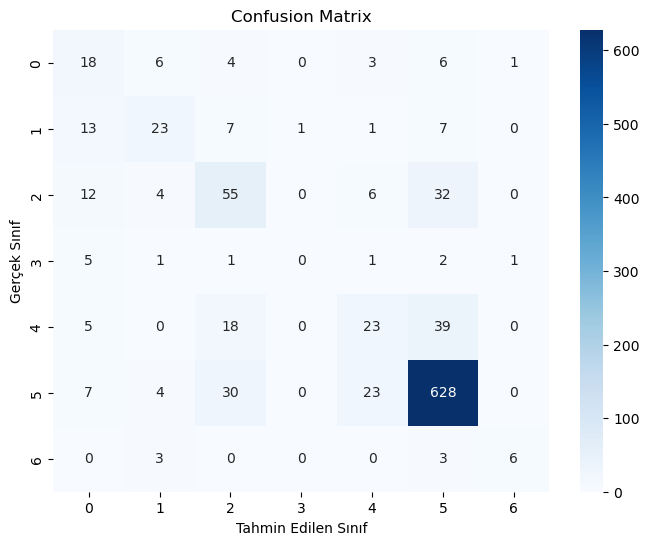

In [42]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix')
plt.show()

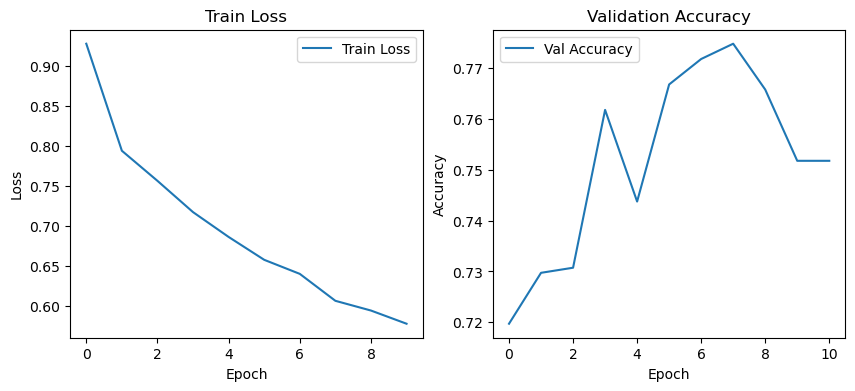

In [43]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()